In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Gerekli kutuphaneleri yukleme

In [3]:
import numpy as np    #Sayısal hesaplamalar ve veri manipülasyonu için kullanılır.
                      #Diziler ve çok boyutlu dizilerle çalışmayı kolaylaştırır.
                      #Hızlı ve verimli vektör operasyonları ve çeşitli matematiksel fonksiyonlar sağlar.

import pandas as pd   #Veri okuma, temizleme, analiz etme ve işleme için kullanılır.

import os             #Dosya ve dizin işlemlerini yapabilmek için kullanılır.
                      #Dosyaların bulunduğu dizini değiştirme veya mevcut dosyaları listeleme vb.
                      #Sistemle etkileşime geçip dosya yollarını yönetmenizi sağlar.

import seaborn as sns #İstatistiksel veri görselleştirmeleri yapar. Matplotlib üzerine kuruludur.
                      #Gelişmiş ve estetik grafikleri oluşturmanızı sağlar.
                      #Veri dağılımını, ilişkilerini ve kategorik verileri gösteren grafikler oluşturmak için kullanılır.


import matplotlib.pyplot as plt #Temel ve esnek veri görselleştirmeleri yapar.

import plotly.express as px #Etkileşimli ve dinamik grafikler oluşturur. Kullanıcıların grafiklerle etkileşime girmesini sağlayan güçlü bir araçtır.
                            #3D grafikler, coğrafi haritalar ve hareketli grafikler gibi ileri seviye görselleştirmeleri destekler.

# 2. Hayvanların Görüntü Yollarını Listeleme

**/kaggle/input/animals-with-attributes-2/** 'deki hayvan türlerine ait görüntü dosyalarının yollarını bulup bunları bir sözlükte saklariz. Sadece 10 sinif kullanacagiz.

In [5]:
import os

image_paths = {}

base_path = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages/"

animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

for dirname, _, filenames in os.walk(base_path):
    for animal in animals:
        if animal in dirname:
            if animal not in image_paths:
                image_paths[animal] = []
            for filename in filenames:
                image_paths[animal].append(os.path.join(dirname, filename))

for animal, paths in image_paths.items():
    print(f"{animal}: {len(paths)} images")


fox: 664 images
giant+panda: 874 images
polar+bear: 868 images
elephant: 1038 images
sheep: 1420 images
collie: 1028 images
moose: 704 images
rabbit: 1088 images
dolphin: 946 images
squirrel: 1200 images


Her bir sinif icin sadece ilk 650 goruntuyu sakliyoruz.

In [6]:
image_paths_final={}

for animal, paths in image_paths.items():
  image_paths_final[animal]=[]
  i=0;
  for path in paths:
    image_paths_final[animal].append(path)
    i+=1
    if i==650:
      break

In [7]:
for animal, paths in image_paths_final.items():
    print(f"{animal}: {len(paths)} images")

fox: 650 images
giant+panda: 650 images
polar+bear: 650 images
elephant: 650 images
sheep: 650 images
collie: 650 images
moose: 650 images
rabbit: 650 images
dolphin: 650 images
squirrel: 650 images


# 3. Resimlerin Yeniden Boyutlandırılması ve Normalize Edilmesi

image_paths_final sözlüğünde yer alan resim dosyalarını okuyoruz, 128x128 olarak yeniden boyutlandırıyor ve normalize ediyoruz. İşlenmiş resimler daha sonra processed_images'de depolanır.

In [8]:
import cv2
import numpy as np

#yeniden boyutlandirmak icin hedef boyut (örneğin, 128x128)
image_size=(128, 128)

# Normalize edilmis ve yeniden boyutlandırılmış resimleri depolamak için yeni bir sözlük

processed_images={}


# image_paths_final sözlüğündeki resimleri işle
for animal, paths in image_paths_final.items():
    processed_images[animal] = [] 
    for path in paths:
        try:
            input_image = cv2.imread(path)
            if input_image is None:
                print(f"Resim okunamadı: {path}")
                continue
            
            # Resmi yeniden boyutlandır
            img_resized = cv2.resize(input_image, image_size)
            
            # Resmi normalize et (pixel değerlerini 0-1 arasına getir)
            img_normalized = img_resized / 255.0
            
            processed_images[animal].append(img_normalized)
        except Exception as e:
            print(f"Bir hata oluştu: {path} - {e}")


Işlenmiş resimler arasından rastgele bir hayvan seçer ve o hayvanın ilk resmini görselleştiririz.

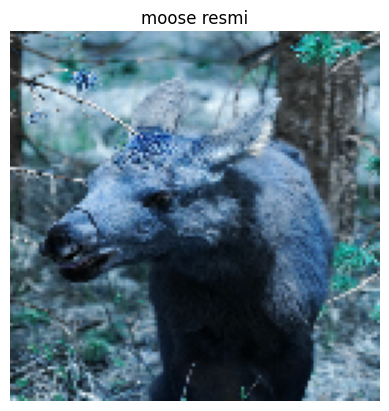

In [9]:
import matplotlib.pyplot as plt
import random

random_animal = random.choice(list(processed_images.keys()))

random_image = processed_images[random_animal][0]


plt.imshow(random_image)
plt.title(f"{random_animal} resmi")
plt.axis('off')  
plt.show()

# 4. Resimlerin augmentasiyonu ve derin ogrenme modelinin egitilmesi

a) Öncelikle görüntüler ve hayvan sınıfları birer listeye toplanıyor. Sınıf etiketleri, modelin anlaması için sayısal değerlere dönüştürülüyor ve veriler %70 eğitim, %30 test olarak bölünüyor. Eğitim verileri üzerinde veri artırma (augmentation) işlemleri uygulanarak farklı dönüşümlerle çeşitlendiriliyor. Bu yöntem, modelin daha genel bir performans göstermesini sağlıyor.

b) Model, üç konvolüsyon katmanı ve bunların ardından gelen havuzlama (pooling) katmanlarından oluşuyor. Görsellerden özellik çıkarmak için konvolüsyon katmanları, işlem verimliliği için havuzlama katmanları kullanılıyor. Overfitting'i önlemek için dropout katmanı ekleniyor. Özellikler, tam bağlantılı (dense) katmana geçmeden önce düzleştiriliyor ve sonunda softmax aktivasyon fonksiyonuyla 10 hayvan sınıfına ayrılıyor.

c) Model, Adam optimizasyon algoritması ve `sparse_categorical_crossentropy` kayıp fonksiyonu kullanılarak derleniyor. Eğitimin her adımında doğrulama verisi ile performans kontrol ediliyor. Model, en iyi doğrulama kaybı değeri elde edildiğinde `best_model.keras` olarak kaydediliyor. Eğitimin tamamlanmasının ardından model, tam haliyle `final_model.keras` dosyasına yazılıyor. 

Bu süreçte, veri artırma ve düzenli kontrol noktası kaydetme yöntemleri sayesinde modelin performansının en üst düzeye çıkarılması hedefleniyor.

In [10]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint  

X = []
y = []

for animal, images in processed_images.items():
    for img in images:
        X.append(img)
        y.append(animal)

X = np.array(X)

# Etiketleri sayısal değerlere dönüştürme
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # String etiketlerini sayısal değerlere dönüştürme

# Eğitim ve test verilerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Veri artırma işlemi için ImageDataGenerator kullanma
datagen = ImageDataGenerator(
    rotation_range=20,         # Dönme
    width_shift_range=0.2,     # Yatay kaydırma
    height_shift_range=0.2,    # Dikey kaydırma
    shear_range=0.2,           # Eğilme
    zoom_range=0.2,            # Yakınlaştırma
    horizontal_flip=True,      # Yatay çevirme
    fill_mode='nearest'        # Piksel değerlerinin doldurulması
)

# X_train'i uygun formata sokma (şekil (örnek sayısı, 128, 128, 3))
X_train_augmented = X_train.reshape((-1, 128, 128, 3))  # (örnek sayısı, yükseklik, genişlik, kanal sayısı)

# Verileri artırma işlemi için fit metodunu çalıştırma
datagen.fit(X_train_augmented)

# Modeli oluşturma
model = models.Sequential()

# 1. Konvolüsyonel Katman (Conv2D)
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))  # 32 filtre, 3x3 çekirdek
model.add(layers.MaxPooling2D((2, 2)))  # MaxPooling katmanı

# 2. Konvolüsyonel Katman
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# 3. Konvolüsyonel Katman
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Dropout katmanı (overfitting'i engellemek için)
model.add(layers.Dropout(0.5))

# Flatten (düzleştirme) katmanı
model.add(layers.Flatten())

# Tam bağlantılı katman (Fully Connected Layer)
model.add(layers.Dense(128, activation='relu'))

# Çıkış katmanı (Softmax aktivasyon fonksiyonu, 10 sınıf için)
model.add(layers.Dense(10, activation='softmax'))  # 10 sınıf olduğu için çıkış katmanında 10 nöron

# Modeli özetle (modelin yapısını görmek için)
model.summary()

# Modeli derlemek
model.compile(optimizer='adam',  # Optimizasyon algoritması
              loss='sparse_categorical_crossentropy',  # Kayıp fonksiyonu
              metrics=['accuracy'])  # Doğruluk metriği

# Callback fonksiyonu ile en iyi modeli kaydetme
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)

# Modeli eğitme (datagen ile artırılmış verilerle) ve model kaydetme
history = model.fit(datagen.flow(X_train_augmented, y_train, batch_size=32),
                    epochs=20,  #30 epoch da kullanilabilir
                    validation_data=(X_test, y_test),
                    callbacks=[checkpoint])  # Callback ekleyerek en iyi modeli kaydediyoruz

# Ayrıca eğitimin sonunda modeli manuel olarak kaydetmek için
model.save('final_model.keras') 


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,930 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2167 - loss: 2.1124
Epoch 1: val_loss improved from inf to 1.78033, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 144ms/step - accuracy: 0.2176 - loss: 2.1104 - val_accuracy: 0.3749 - val_loss: 1.7803
Epoch 2/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3813 - loss: 1.7274
Epoch 2: val_loss improved from 1.78033 to 1.51069, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.3816 - loss: 1.7268 - val_accuracy: 0.4851 - val_loss: 1.5107
Epoch 3/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4340 - loss: 1.6035
Epoch 3: val_loss improved from 1.51069 to 1.34469, saving model to best_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - accuracy: 0.4343 - loss: 1.6029 - val_accuracy: 0.5446 - val_loss: 1.3447
Epoch 4/20
142/143 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.4925 - loss: 1.4667
Epoch 4: val_loss improved from 1.34469 to 1.296

# 5. Modelin ilk test seti uzerinde test edilmesi

Ilk test seti uzerinde 68%'lik bir dogruluk skoru elde ediyoruz. 

In [11]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Kayıp: {test_loss}")
print(f"Test Doğruluk: {test_accuracy}")

61/61 - 0s - 7ms/step - accuracy: 0.6846 - loss: 0.9510
Test Kayıp: 0.9510374069213867
Test Doğruluk: 0.6846153736114502


# 6. Ikinci test setinin hazirlanmasi (resimler manipule edilir)

Simdi test setimizdeki resimleri manipule edip degistirdikten sonra, modelimizin basarisini olcmeyi amacliyoruz. Bunun icin yardimci fonksiyonlarimizi tanimliyoruz.

**linearize_image**: Görüntüyü sRGB formatından lineer RGB formatına dönüştürür. Bu işlem, genellikle daha doğru renk işleme ve beyaz dengeleme için gereklidir. sRGB'deki değerler, doğrusal olmayan bir şekilde sıkıştırılmıştır ve bu işlev, bu sıkıştırmayı düzeltir.

**linear_to_srgb**: Lineer RGB'yi tekrar sRGB'ye dönüştürür. Bu, işlem sonrasında doğru renkleri geri almak için gereklidir.

**handle_saturation**: Görüntüdeki doygun (saturated) olmayan pikselleri bulur ve bu piksellerin renklerinin doğru şekilde işlenmesine olanak tanır.

Renk doğruluğu sağlamak için kullanılan Grey World Assumption yöntemine dayalı bir renk sabitleme fonksiyonu bulunur. Bu fonksiyon, doğru ışık kaynağını tahmin etmek için görüntüdeki geçerli pikselleri kullanır.

**estimate_light_source_grey_world**: Bu fonksiyon, "Grey World" varsayımına göre ışık kaynağını tahmin eder. Bu varsayım, sahnedeki tüm renklerin ortalama renginin nötr (gri) olacağına dayanır. Geçerli (doğru) piksellerin ortalama rengini alarak bu tahmini yapar.

**correct_colors**: Tahmin edilen ışık kaynağına dayanarak, görüntünün renklerini düzeltir. Bu, renk bozulmalarını azaltmak için kullanılır.

**process_and_white_balance** fonksiyonu, yukarıdaki işlevlerin birleşimidir ve görüntüye beyaz dengeleme uygular. Önce görüntü lineer hale getirilir, sonra doygun olmayan pikseller işleme alınarak ışık kaynağı tahmin edilir. Son olarak, bu tahminlere dayalı olarak renkler düzeltilir ve sRGB formatına geri dönüştürülür.


In [12]:


### Fundamental functions
def linearize_image(image):
    """
    Converts an sRGB image to linear RGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.04045,
                    image / 12.92,
                    ((image + 0.055) / 1.055) ** 2.4)


def linear_to_srgb(image):
    """
    Converts a linear RGB image to sRGB assuming the input image is in the range [0, 1]
    """
    return np.where(image <= 0.0031308,
                    image * 12.92,
                    1.055 * (image ** (1 / 2.4)) - 0.055)


def handle_saturation(image, lower=0.05, upper=0.95):
    """
    Creates a mask for non-saturated pixels (those between `lower` and `upper` thresholds)
    """
    return np.all((image > lower) & (image < upper), axis=-1)



### Color constancy
def estimate_light_source_grey_world(image, mask):
    """
    Estimates the light source based on the Grey World assumption, using valid pixels from the mask
    """
    valid_pixels = image[mask]
    avg_color = np.mean(valid_pixels, axis=0)
    return avg_color / np.linalg.norm(avg_color)


def correct_colors(image, light_source):
    """
    Corrects the colors of the image by applying white balance using the estimated light source
    """
    return image * (1.0 / light_source)


Test verilerini manipüle ederek, her bir resme farklı ışık kaynakları altında renk değişiklikleri uyguluyoruz ve sonuçları kaydediyoruz. Ayrıca, manipüle edilen resimlere doğru etiketleri ekliyoruz.

1. **get_light_sources** fonksiyonu, farklı renk tonlarına sahip üç ışık kaynağı döndürür. Bu ışık kaynakları, resimlerin renk manipülasyonunu simüle etmek için kullanılır. Her ışık kaynağı, normalize edilmiş RGB vektörü şeklinde temsil edilir.

2. **manipulate_light_source** fonksiyonu, bir resmin rengini belirtilen ışık kaynağına göre manipüle eder. İlk olarak, resim lineer RGB formatına dönüştürülür. Ardından, her piksele ışık kaynağı uygulanarak resmin renkleri değiştirilir. Son olarak, değiştirilen resim tekrar sRGB formatına dönüştürülür.

3. **get_manipulated_images** fonksiyonu, üç farklı ışık kaynağı altında renk manipülasyonu yaparak her bir resim için üç versiyon üretir. Bu versiyonlar, sırasıyla morumsu, sarımsı ve yeşilimsi ışık kaynakları altında manipüle edilir. Manipüle edilen her resim, uygun dosya adıyla kaydedilir.

4. **manipulate_images_and_labels** fonksiyonu, `X_test` (test verisi) üzerinde her bir resim için manipülasyon işlemi uygular. Her resme ait üç farklı versiyon üretir ve etiketlerini de buna göre çoğaltır. Örneğin, her bir orijinal resim için 3 etiket eklenir (her manipüle edilmiş resme karşılık gelen bir etiket).

Sonuç olarak, bu işlemle 1950 orijinal test resminden 5850 manipüle edilmiş resim elde edilir. Her resim için üç farklı renk manipülasyonu yapılır ve bu resimler, ilgili etiketlerle birlikte kaydedilir.

In [13]:

manipulated_images_folder = "manipulated_test_images/" 
os.makedirs(manipulated_images_folder, exist_ok=True)

def get_light_sources():
    """
    Returns a set of light sources for image manipulation
    """
    purplish_light = np.array([0.82, 0.15, 0.89]) / np.linalg.norm([0.82, 0.15, 0.89])
    yellowish_light = np.array([0.96, 0.24, 0.11]) / np.linalg.norm([0.96, 0.24, 0.11])
    greenish_light = np.array([0.11, 0.98, 0.12]) / np.linalg.norm([0.11, 0.98, 0.12])
    return purplish_light, yellowish_light, greenish_light

def manipulate_light_source(image, light_color):
    """
    Simulates color manipulation under a different light source

    Args:
    - image: The input image (sRGB, [0, 1])
    - light_color: The light source color (unit norm RGB vector)

    Returns:
    - Manipulated image (sRGB, [0, 1])
    """
    linear_image = linearize_image(image)
    manipulated_image = linear_image * light_color
    manipulated_srgb = linear_to_srgb(manipulated_image)
    return np.clip(manipulated_srgb, 0, 1)

def get_manipulated_images(image, image_name):
    """
    Get manipulated images by applying color vectors and save them
    """
    purplish_light, yellowish_light, greenish_light = get_light_sources()

    manipulated_purplish = manipulate_light_source(image, purplish_light)
    manipulated_yellowish = manipulate_light_source(image, yellowish_light)
    manipulated_greenish = manipulate_light_source(image, greenish_light)

    base_filename = os.path.join(manipulated_images_folder, f"{image_name}_")
    cv2.imwrite(f"{base_filename}purplish.jpg", cv2.cvtColor((manipulated_purplish * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(f"{base_filename}yellowish.jpg", cv2.cvtColor((manipulated_yellowish * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))
    cv2.imwrite(f"{base_filename}greenish.jpg", cv2.cvtColor((manipulated_greenish * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))

def manipulate_images_and_labels(X_test, y_test):
    manipulated_images = []
    manipulated_labels = []

    for i, image in enumerate(X_test): 
        image_name = f"test_image_{i+1}"  

        image = image.astype(np.float32) 

        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        get_manipulated_images(image_bgr, image_name)  
        
        label = y_test[i]
        manipulated_labels.extend([label, label, label]) 

    return manipulated_labels


manipulated_labels = manipulate_images_and_labels(X_test, y_test)


print(f"Total number of manipulated images: {len(manipulated_labels)}")  # This should be 5850


Total number of manipulated images: 5850


# 7. Modelin ikinci test seti uzerinde test edilmesi 

Burada, manipüle edilmiş resimler üzerinde modelin başarısını değerlendirmeyi amaçlıyoruz. İlk olarak, load_and_preprocess_images fonksiyonu manipüle edilmiş resimlerin bulunduğu klasörü okuyor. Bu fonksiyon, her bir resmi okur, BGR formatından RGB'ye dönüştürür ve belirtilen boyutta (128x128 piksel) yeniden boyutlandırır. Resimler daha sonra uygun formatta (batch boyutu eklenmiş şekilde) modele girdi olarak kullanılmak üzere hazırlanır.

Sonra, modelin predict fonksiyonu kullanılarak manipüle edilmiş resimler üzerinde tahmin yapılır. Modelin tahmin ettiği sınıflar np.argmax fonksiyonu ile elde edilir, bu da her bir resim için en yüksek olasılığa sahip sınıfı seçer. Gerçek etiketler ise manipulated_labels değişkeninde bulunur. Son olarak, doğru etiketler ile modelin tahminleri karşılaştırılır ve accuracy_score fonksiyonu ile modelin doğruluğu hesaplanır. Sonuç olarak, bu doğruluk yüzde olarak ekrana yazdırılır.

In [23]:


def load_and_preprocess_images(manipulated_images_folder, image_size=(128, 128)):
    images = []
    image_filenames = []
    
   
    for filename in os.listdir(manipulated_images_folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(manipulated_images_folder, filename)
            img = cv2.imread(img_path)  # Load the image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

           
            img_resized = cv2.resize(img, image_size)
            img_array = np.expand_dims(img, axis=0)  # Add batch dimension

            images.append(img_array)
            image_filenames.append(filename)

    return np.vstack(images), image_filenames

X_manipulated, manipulated_image_filenames = load_and_preprocess_images(manipulated_images_folder)

y_pred = model.predict(X_manipulated)
y_pred_labels = np.argmax(y_pred, axis=1)  

y_true = manipulated_labels  

accuracy = accuracy_score(y_true, y_pred_labels)
print(f"Accuracy on manipulated test images: {accuracy * 100:.2f}%")


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy on manipulated test images: 9.47%


SEBEP : Yetersiz Eğitim: Model, manipüle edilmiş resimlerde yeterince iyi performans göstermiyor olabilir. Model, sadece orijinal verilerle eğitildiyse, manipülasyonlardan (farklı ışık kaynakları, renk değişiklikleri) kaynaklanan farklılıklara uyum sağlamakta zorlanabilir. Modelin manipüle edilmiş verilerle eğitim yapılmadığı durumlarda, genellikle düşük doğruluk gözlemlenir. Bu durumu düzeltmek için, modelin manipüle edilmiş verilerle eğitilmesi, etiketlerin doğruluğunun kontrol edilmesi ve veri artırma stratejilerinin gözden geçirilmesi gerekebilir.

# 8. Ucuncu test setinin hazirlanmasi ve modelin yeniden degerlendirilmesi

Manipüle edilmiş test görüntülerine renk sabitliği (white balance) uygulayarak, bu sabitlenmiş resimler üzerinde modelin doğruluğunu değerlendiriyoruz. İlk olarak, manipüle edilmiş test görüntülerinin bulunduğu klasördeki her bir resme renk sabitliği uygulanır. process_and_white_balance fonksiyonu kullanılarak her resmin renk dengesi düzeltilir ve ardından bu sabitlenmiş resimler, belirlenen çıkış klasörüne kaydedilir.

Ardından, renk sabitliği yapılmış resimler, belirtilen boyutlarda yeniden boyutlandırılır ve modelin anlayabileceği uygun formata dönüştürülerek yüklenir. Model, bu sabitlenmiş görüntüler üzerinde tahminler yapar ve bu tahminler, orijinal etiketlerle karşılaştırılır. Son olarak, doğruluk oranı hesaplanır ve ekrana yazdırılır. Bu işlem, renk sabitliği uygulanmış resimler üzerinde modelin başarımını değerlendirir.

**process_and_white_balance fonksiyonu** : Simple Channel Scaling (SCS) yöntemini kullanarak bir görüntüye renk sabitliği (white balance) uygular. Fonksiyonun yaptığı işlemleri kısaca şöyle özetleyebiliriz:

Görüntü Renk Dönüşümü: İlk olarak, girdi olarak alınan RGB formatındaki görüntü, OpenCV'nin BGR formatına dönüştürülür, çünkü OpenCV, BGR formatını kullanır.

Renk Kanalı Ortalama Hesaplaması: Görüntüdeki her bir renk kanalının (mavi, yeşil ve kırmızı) ortalama değerleri hesaplanır.

Genel Ortalama Hesaplama: Bütün renk kanallarının ortalama değerlerinin toplamının ortalaması alınarak genel bir "ortalama renk değeri" bulunur.

Kanal Ölçekleme Faktörleri: Her renk kanalı için, ortalama renk değeri ile o kanalın ortalama değeri arasındaki oran hesaplanır. Bu oranlar, her kanal için ölçekleme faktörleri olarak kullanılır.

Kanal Başına Ölçekleme Uygulama: Hesaplanan ölçekleme faktörleri, her kanalın (mavi, yeşil ve kırmızı) pixel değerlerine uygulanır. Bu, her bir kanalın ortalama değerini, tüm kanallar için ortak bir değere (genel ortalama) uyumlu hale getirir.

Sonuç Görüntüsü: Son olarak, renk kanallarına yapılan ölçekleme işlemi sonrası görüntü, tekrar RGB formatına dönüştürülür ve [0, 1] aralığında normalize edilerek döndürülür.

Bu yöntem, görüntüdeki renk dengesizliklerini düzeltmek ve ışık koşullarını daha doğal hale getirmek için kullanılır.

**get_wb_images** :Bu fonksiyon, verilen bir görüntüyü alır, renk sabitliği uygular ve ardından işlenmiş görüntüyü belirtilen klasöre kaydeder. Renk sabitliği uygular (process_and_white_balance fonksiyonu ile) ve  görüntüyü kaydeder: İşlenmiş görüntü, belirtilen dosya adıyla belirtilen çıkış klasörüne .jpg formatında kaydedilir.

**apply_white_balance_to_images** : Bu fonksiyon, klasördeki tüm .jpg uzantılı görüntülere renk sabitleme uygulamak için kullanılır. Klasördeki her bir görüntü dosyası okunur, renk sabitleme işlemi uygulanır ve işlenmiş görüntüler belirtilen çıkış klasörüne kaydedilir. Çıkış klasörü yoksa, fonksiyon otomatik olarak oluşturur.

**load_white_balanced_images** : Bu fonksiyon, klasördeki tüm beyaz dengesi (white balance) uygulanmış resimleri yükler ve belirtilen boyutlarda (default olarak 128x128) yeniden boyutlandırarak bir dizi (numpy array) olarak döndürür. Her bir görüntü, cv2.imread() ile okunur, RGB formatına dönüştürülür, boyutlandırılır ve numpy array formatında saklanır.

In [29]:
def process_and_white_balance(image):
    """
    Applies white balance using Simple Channel Scaling (SCS) method.
    Returns the corrected image in sRGB format.
    """
    # Convert the image from RGB to BGR for OpenCV compatibility
    img_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    # Calculate the average color for each channel (Blue, Green, Red)
    avg_b = np.mean(img_bgr[:, :, 0])
    avg_g = np.mean(img_bgr[:, :, 1])
    avg_r = np.mean(img_bgr[:, :, 2])

    # Find the average of all channels
    avg_all = (avg_b + avg_g + avg_r) / 3

    # Compute scaling factors for each channel
    scale_b = avg_all / avg_b
    scale_g = avg_all / avg_g
    scale_r = avg_all / avg_r

    # Apply scaling to each channel
    img_bgr[:, :, 0] = np.clip(img_bgr[:, :, 0] * scale_b, 0, 255)  # Blue channel
    img_bgr[:, :, 1] = np.clip(img_bgr[:, :, 1] * scale_g, 0, 255)  # Green channel
    img_bgr[:, :, 2] = np.clip(img_bgr[:, :, 2] * scale_r, 0, 255)  # Red channel

    # Convert the image back to RGB
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    return img_rgb / 255.0  # Normalize the image to [0, 1]


In [30]:
def get_wb_images(image, output_folder, output_filename):
    """
    Process and white balance the image, then save it.
    """
    # Apply white balance
    srgb_grey_world = process_and_white_balance(image)

    # Save the white-balanced image
    output_path = os.path.join(output_folder, output_filename)
    cv2.imwrite(output_path, cv2.cvtColor((srgb_grey_world * 255).astype(np.uint8), cv2.COLOR_RGB2BGR))


In [38]:

def apply_white_balance_to_images(input_folder, output_folder):
    """
    Apply white balance to all images in the input folder and save them in the output folder.
    """
    os.makedirs(output_folder, exist_ok=True) 

    for filename in os.listdir(input_folder):
        if filename.endswith(".jpg"):
            img_path = os.path.join(input_folder, filename)
            img = cv2.imread(img_path)  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            get_wb_images(img, output_folder, f"wb_{filename}")

def load_white_balanced_images(white_balanced_folder, image_size=(128, 128)):
    images = []
    image_filenames = []
    
    for filename in os.listdir(white_balanced_folder):
        if filename.startswith("wb_") and filename.endswith(".jpg"):
            img_path = os.path.join(white_balanced_folder, filename)
            img = cv2.imread(img_path)  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
            
            img_resized = cv2.resize(img, image_size)
            img_array = np.expand_dims(img_resized, axis=0) 

            images.append(img_array)
            image_filenames.append(filename)

    return np.vstack(images), image_filenames

manipulated_images_folder = "manipulated_test_images/" 
white_balanced_folder = "white_balanced_test_images/" 

apply_white_balance_to_images(manipulated_images_folder, white_balanced_folder)

X_white_balanced, wb_image_filenames = load_white_balanced_images(white_balanced_folder)

y_pred_wb = model.predict(X_white_balanced)
y_pred_wb_labels = np.argmax(y_pred_wb, axis=1)

y_true_wb = manipulated_labels  

accuracy_wb = accuracy_score(y_true_wb, y_pred_wb_labels)
print(f"Accuracy on white-balanced test images: {accuracy_wb * 100:.2f}%")


183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Accuracy on white-balanced test images: 10.32%


# 9. Test Setleri ve Sonuçlar

**Orijinal Test Seti:**

Modelin eğitim verisinde yer alan orijinal test seti üzerinde elde edilen doğruluk oranı %68 olarak kaydedilmiştir. Bu, modelin temel performansını yansıtmaktadır ve belirli bir seviyede doğru sınıflandırmalar yapabildiğini göstermektedir.

**Manipüle Edilmiş Test Seti (Üç Farklı Renk Manipülasyonu):**

Bu test setinde, görseller üzerinde üç farklı renk manipülasyonu uygulanmıştır. Renk manipülasyonları, görüntülerdeki renk dengesinin değiştirilmesini içerir. Manipülasyon sonrasında doğruluk oranı %9,47'ye düşmüştür. Bu, modelin renk manipülasyonlarına karşı oldukça hassas olduğunu ve bu tür görsellerde başarılı bir şekilde sınıflandırma yapmada zorlandığını göstermektedir.

**Manipüle Edilmiş Test Setine Beyaz Dengeleme (Renk Sabitleme) Uygulandıktan Sonra:**

Manipülasyonlardan sonra beyaz dengeleme uygulanan test setinde ise modelin doğruluğu %10.32 olarak ölçülmüştür. Beyaz dengeleme, renk tonlarını düzeltmek için kullanılan bir tekniktir ve modelin renk manipülasyonlarına karşı biraz daha dayanıklı hale gelmesini sağlamış gibi görünmektedir. Ancak yine de bu doğruluk oranı oldukça düşük kalmaktadır. Bu durum, modelin görsel manipülasyonlara karşı genelleme yapabilme kapasitesinin yetersiz olduğunu ve beyaz dengelemenin tek başına yeterli olmayabileceğini göstermektedir.

**Düşük Doğruluk Sonuçları ve Çözüm Yolları**

Elde edilen doğruluk oranları, modelin manipülasyonlara ve renk değişikliklerine karşı zayıf olduğunu gösteriyor. Özellikle renk manipülasyonlarının modelin başarısını büyük ölçüde olumsuz etkilediği açıkça görülmektedir. Modelin, manipüle edilmiş görselleri doğru bir şekilde sınıflandırmakta zorlanması, genelleme kapasitesinin sınırlı olduğunu ve eğitim veri setinin çeşitliliğinin arttırılması gerektiğini işaret etmektedir.


Veri Manipülasyonunun Zorluğu: Görsellerin üç farklı renk manipülasyonundan geçirilmesi, modelin bu tür değişikliklere karşı duyarlı hale gelmesine yol açabilir. Bu, modelin genelleme kapasitesinin sınırlı olduğunu ve farklı renk koşullarında başarılı bir şekilde sınıflandırma yapamadığını gösterir.

Beyaz Dengelemenin Yetersizliği: Beyaz dengeleme, görüntüdeki renk dengesini düzeltmeye yönelik bir adımdır, ancak bu işlem tüm renk manipülasyonlarının etkisini ortadan kaldırmayabilir. Modelin daha karmaşık renk manipülasyonlarını etkili bir şekilde öğrenmesi için daha ileri teknikler gerekebilir.

Modelin Genelleme Gücünün Zayıflığı: Eğitim verisi ile test seti arasında önemli farklar varsa (örneğin, manipülasyonlar ve beyaz dengeleme gibi işlemler), modelin bu farklı veri setlerine uyum sağlamakta zorlanması mümkündür. Modelin eğitim verisi, test setinde görülen çeşitlilikle yeterince uyumlu olmayabilir.

**Çözüm Yolları**

Veri Artırma (Data Augmentation): Veri setine daha fazla çeşitlilik eklemek, modelin genelleme yeteneğini artırabilir. Görsellerin farklı açılarda döndürülmesi, kontrast ve parlaklık ayarlarının değiştirilmesi gibi işlemler, modelin farklı koşullar altında daha iyi performans göstermesini sağlayabilir.

Modelin Derinleştirilmesi: Daha derin ve karmaşık bir model (örneğin, daha fazla katmanlı bir CNN) kullanmak, modelin daha fazla özellik öğrenmesini ve renk manipülasyonlarına karşı daha dayanıklı olmasını sağlayabilir. Ayrıca, transfer öğrenme yöntemleri de bu tür problemleri çözmek için etkili olabilir.

Hiperparametre Ayarlamaları: Modelin hiperparametrelerinin (öğrenme oranı, epoch sayısı, vb.) iyileştirilmesi, daha iyi sonuçlar elde edilmesini sağlayabilir. Hiperparametre optimizasyonu, modelin eğitim sürecini daha verimli hale getirebilir.

Beyaz Dengeleme Yöntemlerinin İyileştirilmesi: Beyaz dengeleme algoritmasının daha gelişmiş versiyonları kullanılabilir. Örneğin, daha iyi renk düzeltmeleri sağlayan algoritmalar veya renk bozulmalarını daha etkili bir şekilde düzeltmeye yönelik yeni yöntemler denenebilir.

Daha Fazla Eğitim Verisi: Eğitim verisinin çeşitliliği arttırılabilir. Özellikle farklı ışık koşulları, renk manipülasyonları ve beyaz dengeleme gibi işlemleri içeren verilerle model eğitilirse, modelin bu tür görselleri daha iyi sınıflandırması beklenebilir.

**Sonuç**
Orijinal test setindeki doğruluk oranı %68 iken, manipülasyon ve beyaz dengeleme sonrası doğruluk oranlarında ciddi bir düşüş yaşanmıştır. Bu, modelin renk manipülasyonlarına karşı duyarlı olduğunu ve bu tür test verileriyle başa çıkmada zorlandığını göstermektedir. Elde edilen düşük doğruluk oranları, modelin genelleme kapasitesinin sınırlı olduğunu ve model iyileştirmeleri için farklı stratejiler gerektiğini ortaya koymaktadır. Veri artırma, model derinleştirme, daha iyi beyaz dengeleme teknikleri ve daha fazla veri toplama gibi çözüm yolları, bu sorunun üstesinden gelmek için etkili olabilir.

Renk sabitligi uygulanmis random bir resmi gorsellestirmek icin yardimci kod:

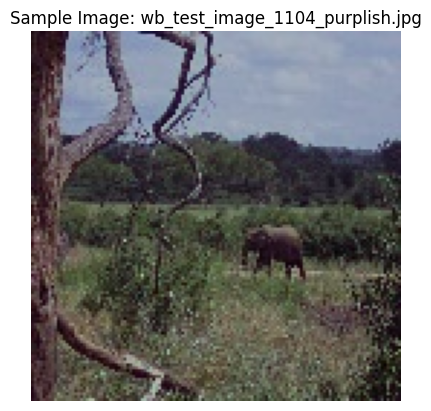

In [40]:
import random
import matplotlib.pyplot as plt

def show_random_sample_image_from_folder(folder_path):
    # Klasördeki tüm .jpg dosyalarını listele
    images = [filename for filename in os.listdir(folder_path) if filename.endswith(".jpg")]
    
    if images:  # Eğer klasörde en az bir .jpg dosyası varsa
        # Rastgele bir resim seç
        random_image = random.choice(images)
        
        # Seçilen resmin yolunu oluştur
        img_path = os.path.join(folder_path, random_image)
        img = cv2.imread(img_path)  # Görüntüyü yükle
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR'den RGB'ye dönüştür
        
        # Görüntüyü matplotlib ile göster
        plt.imshow(img)
        plt.axis('off')  # Eksenleri kaldır
        plt.title(f"Sample Image: {random_image}")
        plt.show()
    else:
        print("Klasörde görüntü bulunamadı.")

# Renk sabitliği uygulanmış resimlerin bulunduğu klasörün yolunu girin
white_balanced_folder = "white_balanced_test_images/"
show_random_sample_image_from_folder(white_balanced_folder)
